## Задаём функцию прогнозирования прогресса по курсу по конкретному пользователю за нужную нам неделю

In [8]:
import joblib
import pandas as pd

def predict_for_user(week, user_id):
    try:
        # Загружаем модель для указанной недели
        model = joblib.load(f'./saved_models/rf_model_week_{week}.joblib')
        
        # Инициализируем переменную для хранения данных
        data = None
        
        # Сначала пытаемся загрузить данные из валидационного набора
        try:
            data = pd.read_csv(f'./saved_datasets/val_week_{week}.csv')
            print(f"Data for validation week {week} loaded successfully.")
            data_source = "validation"
        except FileNotFoundError:
            # Если данные для валидации отсутствуют, загружаем обучающий набор
            data = pd.read_csv(f'./saved_datasets/train_week_{week}.csv')
            print(f"Validation data not found. Using training data for week {week}.")
            data_source = "training"

        # Фильтруем данные по user_id
        user_data = data[data['user_id'] == user_id]
        
        # Проверяем наличие пользователя в загруженной выборке
        if user_data.empty:
            if data_source == "validation":
                print(f"No data found for user_id {user_id} in validation dataset. Checking training dataset.")
                # Загружаем обучающий набор и ищем пользователя там
                data = pd.read_csv(f'./saved_datasets/train_week_{week}.csv')
                user_data = data[data['user_id'] == user_id]
            
            # Проверяем еще раз после загрузки обучающего набора
            if user_data.empty:
                print(f"No data found for user_id {user_id} in both datasets.")
                return None
            
            print(f"User_id {user_id} found in the training dataset for week {week}.")
        
        else:
            print(f"User_id {user_id} found in the validation dataset for week {week}.")

        # Проверка наличия целевого признака
        if 'm2_progress' not in user_data.columns:
            print("Column 'm2_progress' is missing from the dataset.")
            return None

        # Получаем реальное значение целевого признака
        actual_value = user_data['m2_progress'].values[0]
        print(f"Actual value of m2_progress for user_id {user_id}: {actual_value:.2f}")

        # Подготовка данных для предсказания
        X_user = user_data.drop(['m2_progress'], axis=1)
        
        # Получаем список признаков из обучающей модели
        train_features = model.feature_names_in_
        
        # Проверяем наличие необходимых признаков
        missing_features = set(train_features) - set(X_user.columns)
        if missing_features:
            print(f"Week {week} is missing features: {missing_features}")
            return None  # Прерываем выполнение, если есть недостающие признаки
        
        # Заполняем отсутствующие признаки значениями по умолчанию
        for feature in train_features:
            if feature not in X_user.columns:
                X_user[feature] = 0
        
        # Убедитесь, что порядок признаков соответствует обучающим данным
        X_user = X_user[train_features]
        
        # Формируем предсказания модели
        y_pred = model.predict(X_user)

        # Выводим предсказанное значение только один раз
        print(f"Predicted value of m2_progress for user_id {user_id} in week {week}: {y_pred[0]:.2f}")
        
        return y_pred[0]  # Возвращаем предсказанное значение
    
    except FileNotFoundError as e:
        print(f"File not found: {e}")
    except KeyError as e:
        print(f"KeyError for week {week}: {e}")
    except ValueError as e:
        print(f"ValueError for week {week}: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

## Вводим номер недели и user_id, на выходе получаем результат прогнозирования прогресса по курсу

In [9]:
# Тестирование на данных
week_number = 3  # Номер недели
user_id_to_predict = 3914  # Замените на нужный user_id

# Вызов функции для предсказания
prediction = predict_for_user(week_number, user_id_to_predict)

Data for validation week 3 loaded successfully.
User_id 3914 found in the validation dataset for week 3.
Actual value of m2_progress for user_id 3914: 100.00
Predicted value of m2_progress for user_id 3914 in week 3: 93.14


In [10]:
# Создаем выборки по группам для тестирования

# Новые курсы
df_82_test = df_test[df_test['course_id'] == 82]
df_770_test = df_test[df_test['course_id'] == 770]
df_76_test = df_test[df_test['course_id'] == 76]
df_83_test = df_test[df_test['course_id'] == 83]

# Определяем количество недель
num_weeks = 10

# Создаем пустые датафреймы для каждой недели для всех курсов
test_list_82 = []
test_list_770 = []
test_list_76 = []
test_list_83 = []

# Функция для создания выборок по курсам
def create_weekly_dfs(course_df, course_list):
    for week in range(num_weeks, 0, -1):
        test_week = course_df.copy()
        test_week[f'required_activities_delay_{week}_week'] = 0
        test_week[f'success_required_done_{week}_week'] = 0
        test_week[f'mean_result_required_{week}_week'] = 0
        test_week[f'cur_date_progress_{week}_week'] = 0
        test_week[f'current_progress_{week}_week'] = 0
        
        course_list.append(test_week)

# Создаем выборки для каждого курса
create_weekly_dfs(df_82_test, test_list_82)
create_weekly_dfs(df_770_test, test_list_770)
create_weekly_dfs(df_76_test, test_list_76)
create_weekly_dfs(df_83_test, test_list_83)

# Присваиваем переменные для каждой недели из списков
test_week_10_82, test_week_9_82, test_week_8_82, test_week_7_82, test_week_6_82, test_week_5_82, test_week_4_82, test_week_82_82, test_week_2_82, test_week_1_82 = test_list_82

test_week_10_770, test_week_9_770, test_week_8_770, test_week_7_770, test_week_6_770, test_week_5_770, test_week_4_770, test_week_770_770, test_week_2_770, test_week_1_770 = test_list_770

test_week_10_76, test_week_9_76, test_week_8_76, test_week_7_76, test_week_6_76, test_week_5_76, test_week_4_76, test_week_76_76, test_week_2_76, test_week_1_76 = test_list_76

test_week_10_83, test_week_9_83, test_week_8_83, test_week_7_83, test_week_6_83, test_week_5_83, test_week_4_83, test_week_82_83, test_week_2_83, test_week_1_83 = test_list_83
# Теперь у нас есть датафреймы для каждой недели по всем курсам.

In [11]:
import joblib
from sklearn.metrics import mean_absolute_error

# Словарь для хранения MAE
rf_maes_76 = []    # Список для MAE

# Создание DataFrame для хранения предсказаний
rf_predictions_df_76 = pd.DataFrame()

# Цикл от 1 до 10 для использования обученных моделей
for week in range(1, 11):
    # Получаем DataFrame для текущей недели из test_list_76
    df_week_76 = test_list_76[week - 1]  # Предполагаем, что test_list_76 содержит датафреймы для каждой недели
    
    # Подготовка данных для предсказания
    X_week = df_week_76.drop(['end_status', 'm2_progress', 'm2_success'], axis=1)
    y_week = df_week_76['m2_progress']
    
    # Загрузка обученной модели из файла
    try:
        rf_model_76 = joblib.load(f'./saved_models/rf_model_week_{week}.joblib')  # Загружаем модель из файла
    except FileNotFoundError:
        print(f"Model for week {week} not found at './saved_models/rf_model_week_{week}.joblib'.")
        continue  # Пропускаем итерацию, если модель не найдена

    # Предсказания на текущих данных
    predictions = rf_model_76.predict(X_week)
    
    # Вычисление MAE (если у вас есть истинные значения y_week)
    mae = mean_absolute_error(y_week, predictions)
    rf_maes_76.append(mae)  # Добавляем MAE в список

    # Добавление предсказаний в DataFrame
    rf_predictions_df_76[f'predictions_week_{week}'] = predictions

# Вывод MAE для каждой недели
for week in range(10):
    print(f"Week {week + 1} - Mean Absolute Error: {rf_maes_76[week]}")

Week 1 - Mean Absolute Error: 16.130192307692308
Week 2 - Mean Absolute Error: 11.457307692307692
Week 3 - Mean Absolute Error: 9.38
Week 4 - Mean Absolute Error: 7.038076923076923
Week 5 - Mean Absolute Error: 6.479423076923077
Week 6 - Mean Absolute Error: 10.702115384615382
Week 7 - Mean Absolute Error: 15.742115384615387
Week 8 - Mean Absolute Error: 6.295000000000001
Week 9 - Mean Absolute Error: 5.094423076923078
Week 10 - Mean Absolute Error: 4.833269230769231


In [12]:
import joblib
from sklearn.metrics import mean_absolute_error

# Словарь для хранения MAE
rf_maes_82 = []    # Список для MAE

# Создание DataFrame для хранения предсказаний
rf_predictions_df_82 = pd.DataFrame()

# Цикл от 1 до 10 для использования обученных моделей
for week in range(1, 11):
    # Получаем DataFrame для текущей недели из test_list_82
    df_week_82 = test_list_82[week - 1]  # Предполагаем, что test_list_82 содержит датафреймы для каждой недели
    
    # Подготовка данных для предсказания
    X_week = df_week_82.drop(['end_status', 'm2_progress', 'm2_success'], axis=1)
    y_week = df_week_82['m2_progress']
    
    # Загрузка обученной модели из файла
    try:
        rf_model_82 = joblib.load(f'./saved_models/rf_model_week_{week}.joblib')  # Загружаем модель из файла
    except FileNotFoundError:
        print(f"Model for week {week} not found at './saved_models/rf_model_week_{week}.joblib'.")
        continue  # Пропускаем итерацию, если модель не найдена

    # Предсказания на текущих данных
    predictions = rf_model_82.predict(X_week)
    
    # Вычисление MAE (если у вас есть истинные значения y_week)
    mae = mean_absolute_error(y_week, predictions)
    rf_maes_82.append(mae)  # Добавляем MAE в список

    # Добавление предсказаний в DataFrame
    rf_predictions_df_82[f'predictions_week_{week}'] = predictions

# Вывод MAE для каждой недели
for week in range(10):
    print(f"Week {week + 1} - Mean Absolute Error: {rf_maes_82[week]}")

Week 1 - Mean Absolute Error: 14.779246231155778
Week 2 - Mean Absolute Error: 13.383467336683417
Week 3 - Mean Absolute Error: 12.895778894472363
Week 4 - Mean Absolute Error: 10.914170854271358
Week 5 - Mean Absolute Error: 9.123015075376884
Week 6 - Mean Absolute Error: 16.314773869346734
Week 7 - Mean Absolute Error: 20.399497487437184
Week 8 - Mean Absolute Error: 12.628643216080404
Week 9 - Mean Absolute Error: 7.968592964824122
Week 10 - Mean Absolute Error: 6.281608040201005


In [13]:
import joblib
from sklearn.metrics import mean_absolute_error

# Словарь для хранения MAE
rf_maes_83 = []    # Список для MAE

# Создание DataFrame для хранения предсказаний
rf_predictions_df_83 = pd.DataFrame()

# Цикл от 1 до 10 для использования обученных моделей
for week in range(1, 11):
    # Получаем DataFrame для текущей недели из test_list_83
    df_week_83 = test_list_83[week - 1]  # Предполагаем, что test_list_83 содержит датафреймы для каждой недели
    
    # Подготовка данных для предсказания
    X_week = df_week_83.drop(['end_status', 'm2_progress', 'm2_success'], axis=1)
    y_week = df_week_83['m2_progress']
    
    # Загрузка обученной модели из файла
    try:
        rf_model_83 = joblib.load(f'./saved_models/rf_model_week_{week}.joblib')  # Загружаем модель из файла
    except FileNotFoundError:
        print(f"Model for week {week} not found at './saved_models/rf_model_week_{week}.joblib'.")
        continue  # Пропускаем итерацию, если модель не найдена

    # Предсказания на текущих данных
    predictions = rf_model_83.predict(X_week)
    
    # Вычисление MAE (если у вас есть истинные значения y_week)
    mae = mean_absolute_error(y_week, predictions)
    rf_maes_83.append(mae)  # Добавляем MAE в список

    # Добавление предсказаний в DataFrame
    rf_predictions_df_83[f'predictions_week_{week}'] = predictions

# Вывод MAE для каждой недели
for week in range(10):
    print(f"Week {week + 1} - Mean Absolute Error: {rf_maes_83[week]}")

Week 1 - Mean Absolute Error: 11.367261904761905
Week 2 - Mean Absolute Error: 8.953452380952383
Week 3 - Mean Absolute Error: 9.07047619047619
Week 4 - Mean Absolute Error: 9.046964285714285
Week 5 - Mean Absolute Error: 9.524761904761906
Week 6 - Mean Absolute Error: 14.046845238095237
Week 7 - Mean Absolute Error: 13.254107142857142
Week 8 - Mean Absolute Error: 10.080833333333333
Week 9 - Mean Absolute Error: 8.346011904761905
Week 10 - Mean Absolute Error: 7.148630952380953


In [15]:
import joblib
from sklearn.metrics import mean_absolute_error

# Словарь для хранения MAE
rf_maes_770 = []    # Список для MAE

# Создание DataFrame для хранения предсказаний
rf_predictions_df_770 = pd.DataFrame()

# Цикл от 1 до 10 для использования обученных моделей
for week in range(1, 11):
    # Получаем DataFrame для текущей недели из test_list_770
    df_week_770 = test_list_770[week - 1]  # Предполагаем, что test_list_770 содержит датафреймы для каждой недели
    
    # Подготовка данных для предсказания
    X_week = df_week_770.drop(['end_status', 'm2_progress', 'm2_success'], axis=1)
    y_week = df_week_770['m2_progress']
    
    # Загрузка обученной модели из файла
    try:
        rf_model_770 = joblib.load(f'./saved_models/rf_model_week_{week}.joblib')  # Загружаем модель из файла
    except FileNotFoundError:
        print(f"Model for week {week} not found at './saved_models/rf_model_week_{week}.joblib'.")
        continue  # Пропускаем итерацию, если модель не найдена

    # Предсказания на текущих данных
    predictions = rf_model_770.predict(X_week)
    
    # Вычисление MAE (если у вас есть истинные значения y_week)
    mae = mean_absolute_error(y_week, predictions)
    rf_maes_770.append(mae)  # Добавляем MAE в список

    # Добавление предсказаний в DataFrame
    rf_predictions_df_770[f'predictions_week_{week}'] = predictions

# Вывод MAE для каждой недели
for week in range(10):
    print(f"Week {week + 1} - Mean Absolute Error: {rf_maes_770[week]}")

Week 1 - Mean Absolute Error: 16.54375
Week 2 - Mean Absolute Error: 12.09859375
Week 3 - Mean Absolute Error: 12.272343750000001
Week 4 - Mean Absolute Error: 12.281484375
Week 5 - Mean Absolute Error: 13.19671875
Week 6 - Mean Absolute Error: 17.850546875
Week 7 - Mean Absolute Error: 17.016640625
Week 8 - Mean Absolute Error: 12.255859375
Week 9 - Mean Absolute Error: 9.133359375
Week 10 - Mean Absolute Error: 7.7875781250000005


In [16]:
test_rf_maes = pd.DataFrame()
test_rf_maes['course_76'] = rf_maes_76
test_rf_maes['course_82'] = rf_maes_82
test_rf_maes['course_770'] = rf_maes_770
test_rf_maes['course_83'] = rf_maes_83
test_rf_maes.index = [f'week_{i}' for i in range(1, len(test_rf_maes) + 1)]

test_rf_maes = test_rf_maes.T
test_rf_maes

,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10
course_76,16.130192,11.457308,9.380000,7.038077,6.479423,10.702115,15.742115,6.295000,5.094423,4.833269
course_82,14.779246,13.383467,12.895779,10.914171,9.123015,16.314774,20.399497,12.628643,7.968593,6.281608
course_770,16.543750,12.098594,12.272344,12.281484,13.196719,17.850547,17.016641,12.255859,9.133359,7.787578
course_83,11.367262,8.953452,9.070476,9.046964,9.524762,14.046845,13.254107,10.080833,8.346012,7.148631


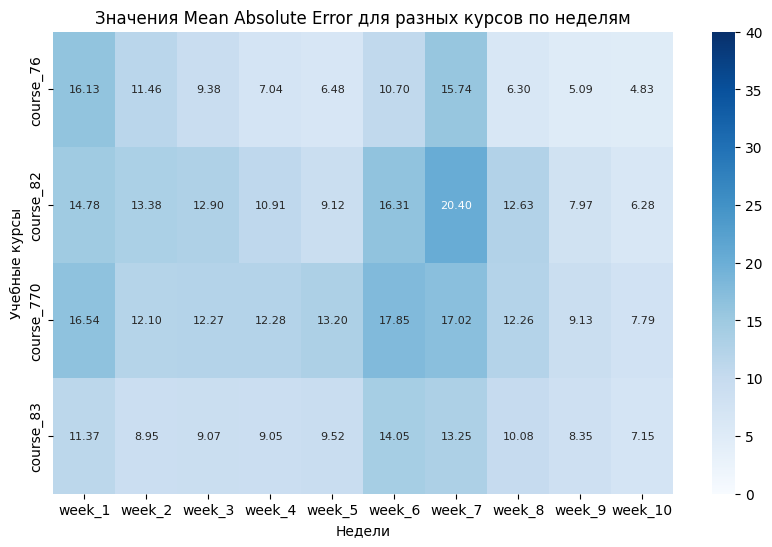

In [17]:
# Создание матрицы для тепловой карты
import matplotlib.pyplot as plt
import seaborn as sns

heatmap_data = test_rf_maes

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', fmt=".2f", annot_kws={"size": 8}, vmin=0, vmax=40)
plt.title('Значения Mean Absolute Error для разных курсов по неделям')
plt.xlabel('Недели')
plt.ylabel('Учебные курсы')
# plt.savefig('./outputs/maes_test_groups.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
new_maes = pd.read_csv('new_maes.csv')
new_maes.reset_index(drop=True, inplace=True)

In [19]:
test_rf_maes.reset_index(drop=True, inplace=True)

In [20]:
difference = test_rf_maes - new_maes

# Сброс индексов и переименование
difference.reset_index(drop=True, inplace=True)  # Сбрасываем индексы без добавления старого индекса как столбца
difference.index = [76, 82, 770, 83]              # Переименовываем индексы
difference.rename_axis('Курс', inplace=True)     # Переименовываем заголовок индекса
difference = difference.drop(difference.columns[[0, 1]], axis=1)
difference

,week_10,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9
Курс,,,,,,,,,
76,-7.708159,-16.813168,-22.580476,-17.129066,-13.115339,-8.735504,-6.100742,-6.587381,-6.238434
82,-10.311077,-17.533107,-13.267740,-14.711755,-13.691707,-8.236893,-4.105040,-8.137653,-10.512796
770,-3.760973,-20.951116,-15.333308,-12.772139,-8.480817,-7.451047,-5.836548,-2.532112,-2.911858
83,-8.869722,-15.265254,-15.981171,-15.006095,-12.023473,-8.819861,-7.624716,-6.789284,-8.302929


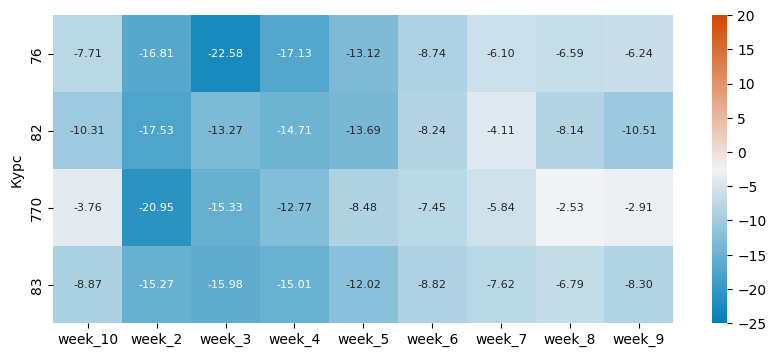

In [25]:
# Рассчитаем и визуализируем разницу в качестве прогнозирования на старой и новой моделях
import matplotlib.pyplot as plt
import seaborn as sns

# Ваши данные
heatmap_data = difference

plt.figure(figsize=(10, 4))

# Создаем палитру: холодные цвета для значений ниже 0 и теплые для значений выше 0
# Используем нейтральный цвет (например, белый) для значения 0
cmap = sns.diverging_palette(240, 20, s=100, l=50, as_cmap=True)

# Создаем пользовательскую палитру с нейтральным цветом для 0
cmap.set_under('lightblue')  # Цвет для значений ниже 0
cmap.set_over('lightcoral')   # Цвет для значений выше 0
cmap.set_bad('lightgrey')      # Цвет для NaN значений

# Создаем тепловую карту
sns.heatmap(heatmap_data, annot=True, cmap=cmap, fmt=".2f", 
            annot_kws={"size": 8}, vmin=-25, vmax=20)

# Сохранение графика (раскомментируйте, если нужно)
# plt.savefig('./outputs/difference.png', dpi=300, bbox_inches='tight')
plt.show()